In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
from imblearn.combine import SMOTEENN

In [2]:

medical_selected_columns = [
    'VDRL_RESULT', 'PLAN_PREGNANCY',
    'HAS_PREG_RISK', 'MARITAL_STATUS',
    'FOOD_INSECURITY', 'NUM_ABORTIONS', 'NUM_LIV_CHILDREN', 'NUM_PREGNANCIES',
    'FAM_PLANNING', 'FAM_INCOME', 'AGE'
]
medical_categorical_columns = [
    'PLAN_PREGNANCY',
    'HAS_PREG_RISK', 'MARITAL_STATUS',
    'FOOD_INSECURITY', 'NUM_ABORTIONS', 'NUM_LIV_CHILDREN', 'NUM_PREGNANCIES',
    'FAM_PLANNING', 'FAM_INCOME'
]
medical_numerical_columns = ['NUM_ABORTIONS', 'NUM_LIV_CHILDREN', 'NUM_PREGNANCIES', 'FAM_INCOME', 'AGE']


In [3]:
df = pd.read_csv('data_set.csv')
df = df[medical_selected_columns]
df.head()

,VDRL_RESULT,PLAN_PREGNANCY,HAS_PREG_RISK,MARITAL_STATUS,FOOD_INSECURITY,NUM_ABORTIONS,NUM_LIV_CHILDREN,NUM_PREGNANCIES,FAM_PLANNING,FAM_INCOME,AGE
0,1.0,1.0,1.0,0.0,0.0,3.0,4.0,4.0,0.0,0.0,25.0
1,1.0,1.0,1.0,5.0,0.0,3.0,4.0,1.0,1.0,2.0,25.0
2,1.0,1.0,1.0,5.0,2.0,0.0,0.0,1.0,0.0,3.0,24.0
3,1.0,0.0,0.0,5.0,2.0,3.0,2.0,3.0,0.0,0.0,28.0
4,1.0,1.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,27.0


In [4]:
duplicates = df.duplicated()

num_duplicates = duplicates.sum()

print(f'Number of duplicate rows: {num_duplicates}')

df = df.drop_duplicates()

df.reset_index(drop=True, inplace=True)

Number of duplicate rows: 18208


In [5]:
max_value_counts = {}
for column in medical_categorical_columns:
    max_value = df[column].max()
    max_count = (df[column] == max_value).sum()
    max_value_counts[column] = max_count

print(f'Numero de não informados nas colunas:\n{max_value_counts}')


Numero de não informados nas colunas:
{'PLAN_PREGNANCY': np.int64(1652), 'HAS_PREG_RISK': np.int64(1656), 'MARITAL_STATUS': np.int64(9580), 'FOOD_INSECURITY': np.int64(9364), 'NUM_ABORTIONS': np.int64(10691), 'NUM_LIV_CHILDREN': np.int64(9400), 'NUM_PREGNANCIES': np.int64(3232), 'FAM_PLANNING': np.int64(5906), 'FAM_INCOME': np.int64(6063)}


In [6]:
#metodo de preencher os nao informados pela moda (SO RODE SE QUISER PREENCHER, SE NAO PULE A CELULA)
# for column in medical_categorical_columns:
#     max_value = df[column].max()

#     df[column] = df[column].replace(max_value, np.nan)
#     mode_value = df[column].mode()[0]
#     df[column].fillna(mode_value, inplace=True)

In [7]:
for col in medical_categorical_columns:
  if col in df.columns:
    df[col] = df[col].astype('category')

df.dtypes


VDRL_RESULT          float64
PLAN_PREGNANCY      category
HAS_PREG_RISK       category
MARITAL_STATUS      category
FOOD_INSECURITY     category
NUM_ABORTIONS       category
NUM_LIV_CHILDREN    category
NUM_PREGNANCIES     category
FAM_PLANNING        category
FAM_INCOME          category
AGE                  float64
dtype: object

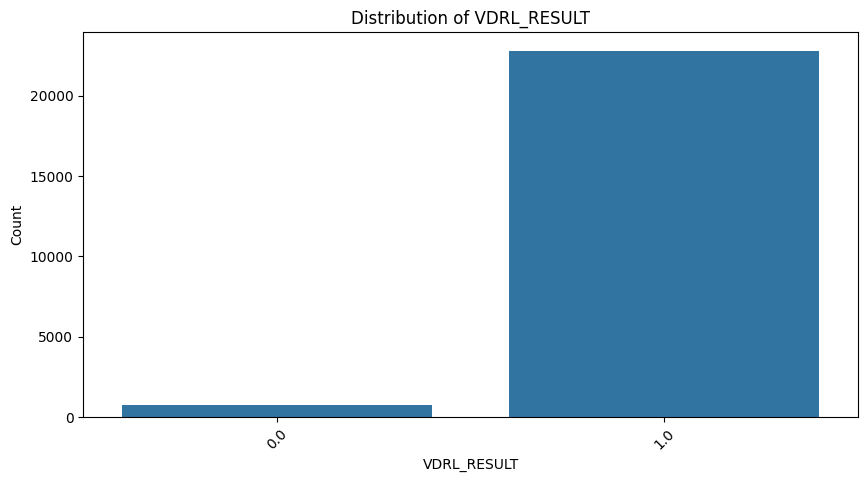

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(x='VDRL_RESULT', data=df)
plt.title(f'Distribution of VDRL_RESULT')
plt.xlabel('VDRL_RESULT')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

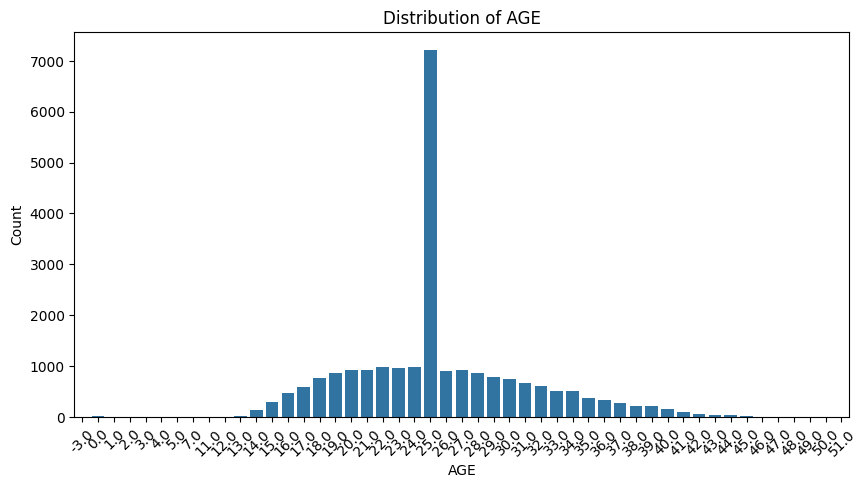

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(x='AGE', data=df)
plt.title(f'Distribution of AGE')
plt.xlabel('AGE')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [10]:
#PLOTAGEM PARA VER A DISTRIBUICAO DAS COLUNAS
# for col in medical_selected_columns:
#     plt.figure(figsize=(10, 5))
#     sns.countplot(x=col, data=df)
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Count')
#     plt.xticks(rotation=45)
#     plt.show()

In [11]:
negative_ages = df[df['AGE'] < 0]
print(f"Number of negative ages: {negative_ages.shape[0]}")
df = df[(df['AGE'] >= 10) & (df['AGE'] <= 50)]

Number of negative ages: 1


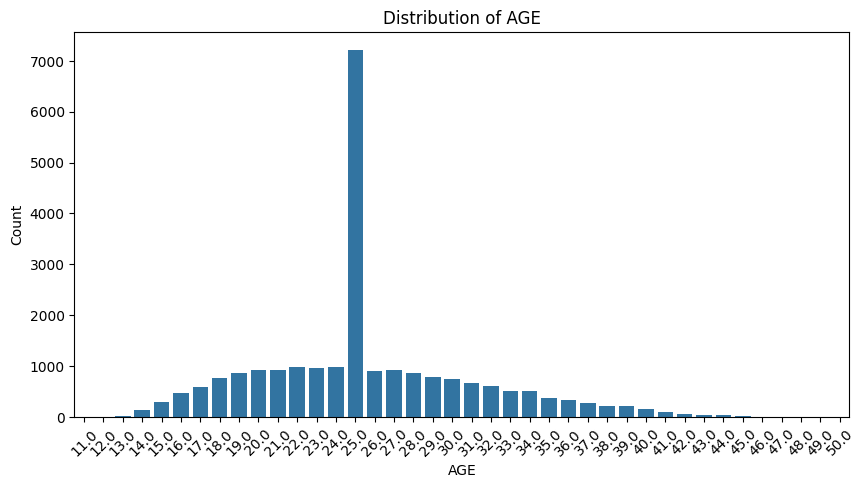

In [12]:
plt.figure(figsize=(10, 5))
sns.countplot(x='AGE', data=df)
plt.title(f'Distribution of AGE')
plt.xlabel('AGE')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

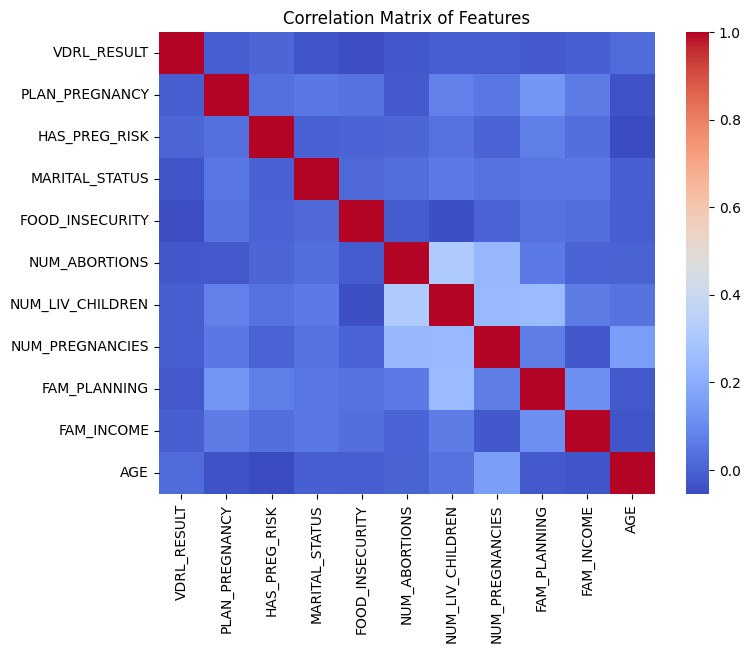

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

In [14]:
df_encoded = pd.get_dummies(df, columns = medical_categorical_columns, drop_first = False)

In [15]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

X = df_encoded.drop(columns=['VDRL_RESULT'])
y = df['VDRL_RESULT']

undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

print("Distribuição original:", Counter(y))
print("Distribuição após under-sampling:", Counter(y_resampled))


Distribuição original: Counter({1.0: 22751, 0.0: 761})
Distribuição após under-sampling: Counter({0.0: 761, 1.0: 761})


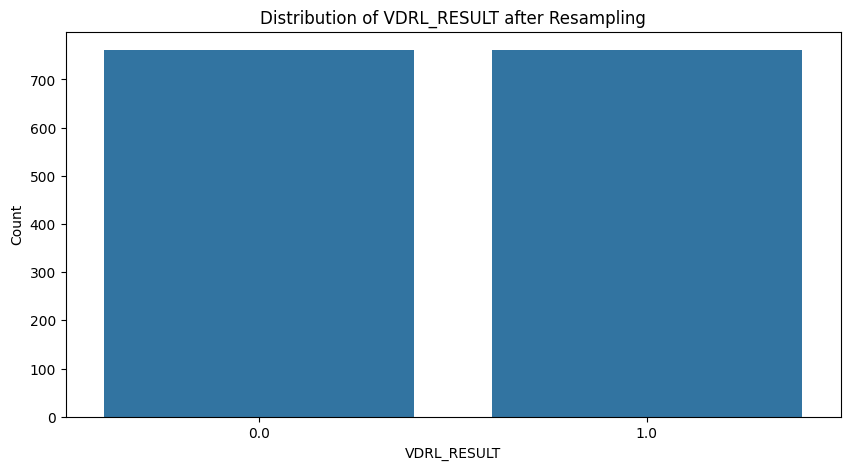

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(x=y_resampled)
plt.title('Distribution of VDRL_RESULT after Resampling')
plt.xlabel('VDRL_RESULT')
plt.ylabel('Count')
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1065, 37), (457, 37), (1065,), (457,))

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

dt_classifier = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_dt = GridSearchCV(estimator=dt_classifier, param_grid=param_grid,
                           scoring='f1_macro', cv=kfold, n_jobs=-1)

grid_search_dt.fit(X_train, y_train)

print(f'Best F1-Score train: {grid_search_dt.best_score_}')
print(f'Best Hyperparameters: {grid_search_dt.best_params_}')


Best F1-Score train: 0.5769897917770451
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_score, recall_score

best_model_tree = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    random_state=42
)

best_model_tree.fit(X_train, y_train)

y_pred = best_model_tree.predict(X_test)

f1_tree = f1_score(y_test, y_pred, average='macro')
accuracy_tree = accuracy_score(y_test, y_pred)
precision_tree = precision_score(y_test, y_pred, average='macro')
recall_tree = recall_score(y_test, y_pred, average='macro')
report_tree = classification_report(y_test, y_pred)

print(f'F1-Score (Test): {f1_tree}')
print(f'Accuracy (Test): {accuracy_tree}')
print(f'Precision (Test): {precision_tree}')
print(f'Recall (Test): {recall_tree}')
print("Classification Report:\n", report_tree)


F1-Score (Test): 0.5645430821901409
Accuracy (Test): 0.5645514223194749
Precision (Test): 0.5648566830165542
Recall (Test): 0.5648840329691394
Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.58      0.56       222
         1.0       0.58      0.55      0.57       235

    accuracy                           0.56       457
   macro avg       0.56      0.56      0.56       457
weighted avg       0.57      0.56      0.56       457



Top 10 Features por Importância:
                Feature  Importance
0                   AGE    0.196949
15  FOOD_INSECURITY_2.0    0.052216
34       FAM_INCOME_1.0    0.050514
19    NUM_ABORTIONS_3.0    0.045900
31     FAM_PLANNING_1.0    0.043805
30     FAM_PLANNING_0.0    0.041635
8    MARITAL_STATUS_1.0    0.036492
33       FAM_INCOME_0.0    0.035790
27  NUM_PREGNANCIES_2.0    0.034269
13  FOOD_INSECURITY_0.0    0.033330


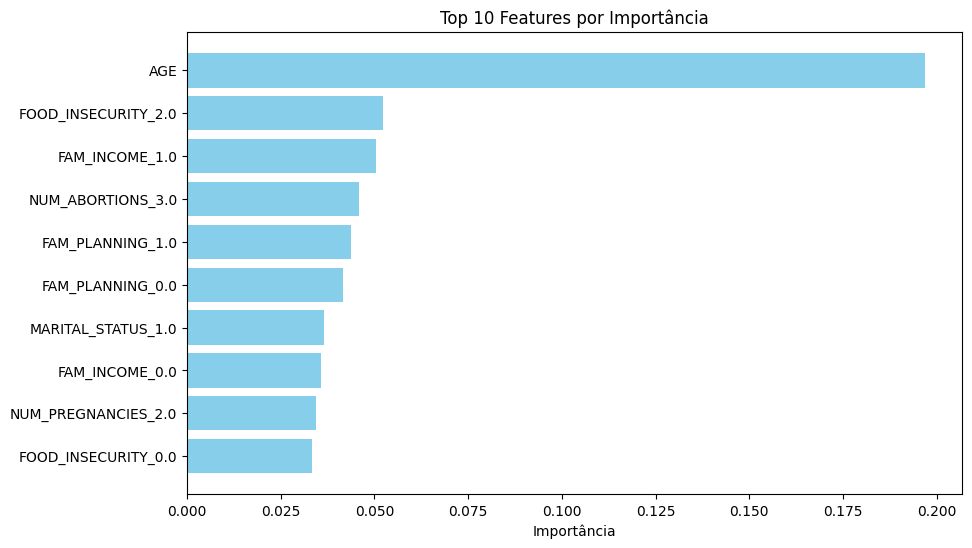

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

feature_names = X_train.columns

importances = best_model_tree.feature_importances_

feature_importances_tree = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances_tree = feature_importances_tree.sort_values(by='Importance', ascending=False)

top_10_features_tree = feature_importances_tree.head(10)

print("Top 10 Features por Importância:")
print(top_10_features_tree)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features_tree['Feature'][::-1], top_10_features_tree['Importance'][::-1], color='skyblue')
plt.xlabel('Importância')
plt.title('Top 10 Features por Importância')
plt.show()


In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='f1_macro', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f'Best F1-Score (XGBoost) train: {grid_search.best_score_}')
print(f'Best Hyperparameters: {grid_search.best_params_}')


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best F1-Score (XGBoost) train: 0.6120946761098688
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}


C:\Users\caiob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

best_xgb_model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=50,
    subsample=0.8,
    random_state=42
)

best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred)
precision_xgb = precision_score(y_test, y_pred, average='macro')
recall_xgb = recall_score(y_test, y_pred, average='macro')
f1_xgb = f1_score(y_test, y_pred, average='macro')
report_tree = classification_report(y_test, y_pred)

print(f'Accuracy (Test): {accuracy_xgb}')
print(f'Precision (Test): {precision_xgb}')
print(f'Recall (Test): {recall_xgb}')
print(f'F1 Score (Test): {f1_xgb}')
print("Classification Report:\n", report_tree)

Accuracy (Test): 0.612691466083151
Precision (Test): 0.6127231287826553
Recall (Test): 0.6128138777074947
F1 Score (Test): 0.6126246929070508
Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.62      0.61       222
         1.0       0.63      0.61      0.62       235

    accuracy                           0.61       457
   macro avg       0.61      0.61      0.61       457
weighted avg       0.61      0.61      0.61       457




Top 10 Features por Importância (Gradient Boosting):
                 Feature  Importance
8     MARITAL_STATUS_1.0    0.048237
11    MARITAL_STATUS_4.0    0.040415
2     PLAN_PREGNANCY_1.0    0.035954
27   NUM_PREGNANCIES_2.0    0.034988
15   FOOD_INSECURITY_2.0    0.033475
0                    AGE    0.032495
3     PLAN_PREGNANCY_2.0    0.031723
17     NUM_ABORTIONS_1.0    0.029903
12    MARITAL_STATUS_5.0    0.029880
22  NUM_LIV_CHILDREN_2.0    0.029777


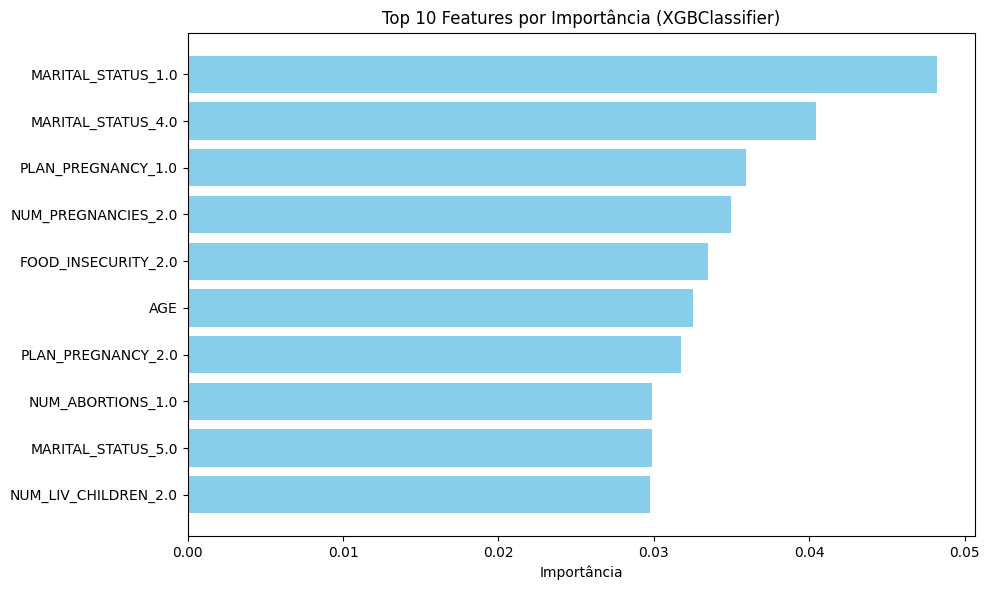

In [24]:
importances = best_xgb_model.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

top_10_features = feature_importances.head(10)

print("\nTop 10 Features por Importância (Gradient Boosting):")
print(top_10_features)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'][::-1], top_10_features['Importance'][::-1], color='skyblue')
plt.xlabel('Importância')
plt.title('Top 10 Features por Importância (XGBClassifier)')
plt.tight_layout()
plt.show()

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

gb_classifier = GradientBoostingClassifier(random_state=42)

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
}

grid_search_gb = GridSearchCV(estimator=gb_classifier, param_grid=param_grid_gb,
                             scoring='f1_macro', cv=5, n_jobs=-1, verbose=1)

grid_search_gb.fit(X_train, y_train)

print(f'Best F1-Score (Gradient Boosting) (Train): {grid_search_gb.best_score_}')
print(f'Best Hyperparameters (Gradient Boosting) (Train): {grid_search_gb.best_params_}')

best_gb_model = grid_search_gb.best_estimator_

y_pred_gb = best_gb_model.predict(X_test)

f1_gb = f1_score(y_test, y_pred_gb, average='macro')
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, average='macro')
recall_gb = recall_score(y_test, y_pred_gb, average='macro')
report_gb = classification_report(y_test, y_pred_gb)

print(f'F1-Score (Test): {f1_gb}')
print(f'Accuracy (Test): {accuracy_gb}')
print(f'Precision (Test): {precision_gb}')
print(f'Recall (Test): {recall_gb}')

print("Classification Report (Gradient Boosting):\n", report_gb)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best F1-Score (Gradient Boosting) (Train): 0.610606004773713
Best Hyperparameters (Gradient Boosting) (Train): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
F1-Score (Test): 0.6059740956468425
Accuracy (Test): 0.6061269146608315
Precision (Test): 0.6075867774955745
Recall (Test): 0.6071784550507955
Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

         0.0       0.59      0.64      0.61       222
         1.0       0.63      0.57      0.60       235

    accuracy                           0.61       457
   macro avg       0.61      0.61      0.61       457
weighted avg       0.61      0.61      0.61       457




Top 10 Features por Importância (Gradient Boosting):
                Feature  Importance
0                   AGE    0.266980
2    PLAN_PREGNANCY_1.0    0.052881
8    MARITAL_STATUS_1.0    0.047011
4     HAS_PREG_RISK_0.0    0.032355
34       FAM_INCOME_1.0    0.032115
28  NUM_PREGNANCIES_3.0    0.031451
16    NUM_ABORTIONS_0.0    0.030998
13  FOOD_INSECURITY_0.0    0.029209
36       FAM_INCOME_3.0    0.029182
15  FOOD_INSECURITY_2.0    0.026926


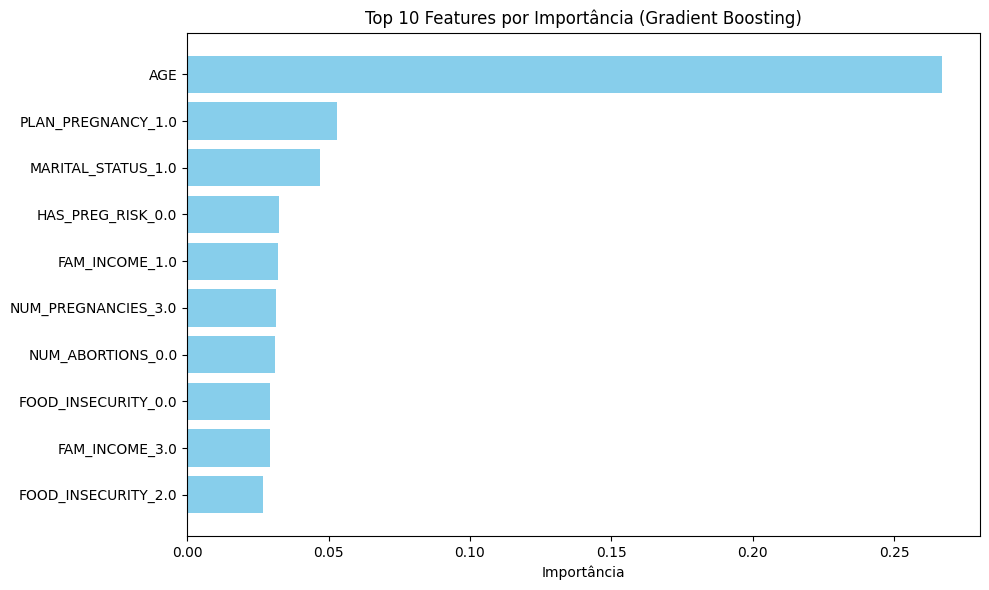

In [26]:
importances = best_gb_model.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

top_10_features = feature_importances.head(10)

print("\nTop 10 Features por Importância (Gradient Boosting):")
print(top_10_features)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'][::-1], top_10_features['Importance'][::-1], color='skyblue')
plt.xlabel('Importância')
plt.title('Top 10 Features por Importância (Gradient Boosting)')
plt.tight_layout()
plt.show()

In [27]:

model_data_result = {
    'Métricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Decision Tree': [accuracy_tree, precision_tree, recall_tree, f1_tree],
    'XGBoost': [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb],
    'Gradient Boosting': [accuracy_gb, precision_gb, recall_gb, f1_gb]
}

metrics_df = pd.DataFrame(model_data_result)


In [28]:
metrics_melted = metrics_df.melt(id_vars='Métricas', var_name='Modelo', value_name='Valor')
print(metrics_melted)


     Métricas             Modelo     Valor
0    Accuracy      Decision Tree  0.564551
1   Precision      Decision Tree  0.564857
2      Recall      Decision Tree  0.564884
3    F1 Score      Decision Tree  0.564543
4    Accuracy            XGBoost  0.612691
5   Precision            XGBoost  0.612723
6      Recall            XGBoost  0.612814
7    F1 Score            XGBoost  0.612625
8    Accuracy  Gradient Boosting  0.606127
9   Precision  Gradient Boosting  0.607587
10     Recall  Gradient Boosting  0.607178
11   F1 Score  Gradient Boosting  0.605974


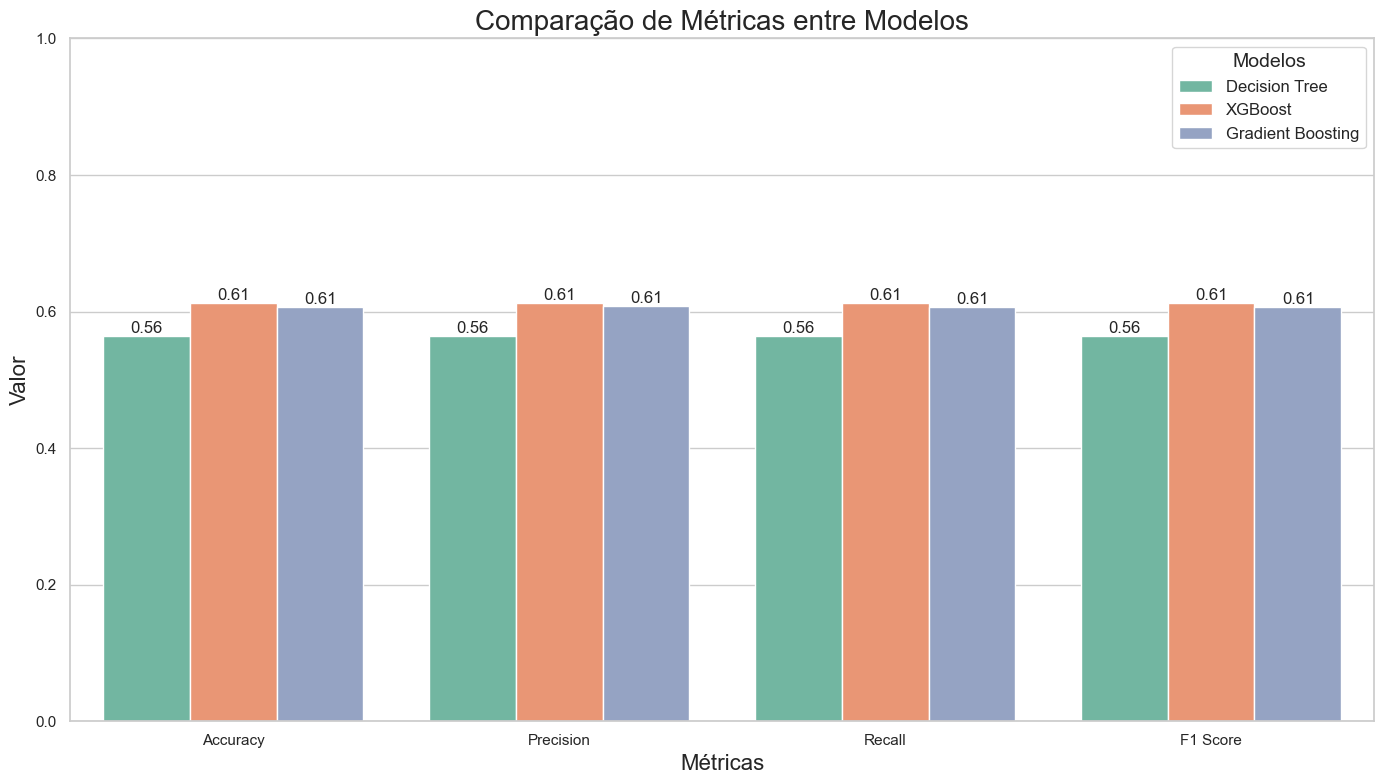

In [29]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))

sns.barplot(x='Métricas', y='Valor', hue='Modelo', data=metrics_melted, palette='Set2')

plt.title('Comparação de Métricas entre Modelos', fontsize=20)
plt.xlabel('Métricas', fontsize=16)
plt.ylabel('Valor', fontsize=16)

for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f', fontsize=12)

plt.legend(title='Modelos', fontsize=12, title_fontsize=14)

# plt.xticks(rotation=45)

plt.ylim(0, 1)

plt.tight_layout()
plt.show()


# Regressão para a variavel `AGE`

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [31]:
columns_to_drop = ["RH_FACTOR", "BLOOD_GROUP", "HAS_FRU_TREE", "HAS_VEG_GARDEN", "WATER_TREATMENT", "CONN_SEWER_NET", "FOOD_INSECURITY"]

categorical_columns = [
    'VDRL_RESULT',
    'SMOKER',
    'CONS_ALCOHOL',
    'NUM_ABORTIONS'
    'PLAN_PREGNANCY',
    'HAS_PREG_RISK', 'TET_VACCINE', 'IS_HEAD_FAMILY', 'MARITAL_STATUS',
    'FAM_PLANNING', 'TYPE_HOUSE', 'HAS_FAM_INCOME', 'LEVEL_SCHOOLING', 'HOUSING_STATUS'
]

In [32]:
df_age = pd.read_csv('data_set.csv')

In [33]:
duplicates = df_age.duplicated()

num_duplicates = duplicates.sum()

print(f'Number of duplicate rows: {num_duplicates}')

df_age = df_age.drop_duplicates()

df_age.reset_index(drop=True, inplace=True)

Number of duplicate rows: 833


In [34]:
negative_ages = df_age[df_age['AGE'] < 0]
print(f"Number of negative ages: {negative_ages.shape[0]}")
df_age = df_age[df_age['AGE'] > 0]

Number of negative ages: 1


In [35]:
df_age = df_age.drop(columns=columns_to_drop)
for col in categorical_columns:
  if col in df_age.columns:
    df_age[col] = df_age[col].astype('category')

df_age.dtypes

VDRL_RESULT          category
CONS_ALCOHOL         category
SMOKER               category
PLAN_PREGNANCY        float64
HAS_PREG_RISK        category
TET_VACCINE          category
IS_HEAD_FAMILY       category
MARITAL_STATUS       category
NUM_ABORTIONS         float64
NUM_LIV_CHILDREN      float64
NUM_PREGNANCIES       float64
FAM_PLANNING         category
TYPE_HOUSE           category
HAS_FAM_INCOME       category
LEVEL_SCHOOLING      category
NUM_RES_HOUSEHOLD     float64
FAM_INCOME            float64
HOUSING_STATUS       category
AGE                   float64
dtype: object

In [36]:
X = df_age.drop(columns=['AGE'])
y = df_age['AGE']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [38]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [39]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

y_pred_linear = linear_model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mape_linear = mean_absolute_percentage_error(y_test, y_pred_linear)

print(f'Mean Squared Error (Linear Regression): {mse_linear}')
print(f'Mean Absolute Error (Linear Regression): {mae_linear}')
print(f'Mean Absolute Percentage Error (Linear Regression): {mape_linear}')



Mean Squared Error (Linear Regression): 19.85884458680253
Mean Absolute Error (Linear Regression): 2.9007144975074217
Mean Absolute Percentage Error (Linear Regression): 0.12094931495866172


In [40]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV


gbr = GradientBoostingRegressor(random_state=42)
param_dist_gbr = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
rand_search_gbr = RandomizedSearchCV(gbr, param_dist_gbr, cv=3, scoring='neg_mean_squared_error', n_iter=5, random_state=42)
rand_search_gbr.fit(X_train, y_train)

best_gbr_model = rand_search_gbr.best_estimator_
y_pred_gbr = best_gbr_model.predict(X_test)
print(f'Best Hyperparameters (Gradient Boosting Regressor): {rand_search_gbr.best_params_}')

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mape_gbr = mean_absolute_percentage_error(y_test, y_pred_gbr)

print(f'Mean Squared Error (Gradient Boosting): {mse_gbr}')
print(f'Mean Absolute Error (Gradient Boosting): {mae_gbr}')
print(f'Mean Absolute Percentage Error (Gradient Boosting): {mape_gbr}')


Best Hyperparameters (Gradient Boosting Regressor): {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
Mean Squared Error (Gradient Boosting): 16.986897603813134
Mean Absolute Error (Gradient Boosting): 2.894116694380836
Mean Absolute Percentage Error (Gradient Boosting): 0.12001389392316708


In [41]:
feature_importances = best_gbr_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Top 10 Feature Importance:")
print(feature_importance_df.head(10))

Top 10 Feature Importance:
              Feature  Importance
10    NUM_PREGNANCIES    0.229787
14    LEVEL_SCHOOLING    0.221630
9    NUM_LIV_CHILDREN    0.125546
7      MARITAL_STATUS    0.099772
15  NUM_RES_HOUSEHOLD    0.049942
6      IS_HEAD_FAMILY    0.035110
4       HAS_PREG_RISK    0.028484
3      PLAN_PREGNANCY    0.027376
8       NUM_ABORTIONS    0.024593
16         FAM_INCOME    0.024490


In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rfr = RandomForestRegressor(random_state=42)
param_dist_rfr = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rand_search_rfr = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=param_dist_rfr,
    cv=3,
    scoring='neg_mean_squared_error',
    n_iter=5,
    random_state=42
)

rand_search_rfr.fit(X_train, y_train)

best_rfr_model = rand_search_rfr.best_estimator_
y_pred_rfr = best_rfr_model.predict(X_test)

print(f'Best Hyperparameters (Random Forest Regressor): {rand_search_rfr.best_params_}')

# Avaliação
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
mape_rfr = mean_absolute_percentage_error(y_test, y_pred_rfr)

print(f'Mean Squared Error (Random Forest): {mse_rfr}')
print(f'Mean Absolute Error (Random Forest): {mae_rfr}')
print(f'Mean Absolute Percentage Error (Random Forest): {mape_rfr}')


Best Hyperparameters (Random Forest Regressor): {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 7}
Mean Squared Error (Random Forest): 17.472113963056092
Mean Absolute Error (Random Forest): 2.87672204643101
Mean Absolute Percentage Error (Random Forest): 0.11951422142608673


In [43]:
feature_importances_rfr = best_rfr_model.feature_importances_

feature_importance_rfr = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_rfr})

feature_importance_rfr = feature_importance_rfr.sort_values(by='Importance', ascending=False)

print("Top 10 Feature Importance:")
print(feature_importance_rfr.head(10))

Top 10 Feature Importance:
              Feature  Importance
10    NUM_PREGNANCIES    0.305852
14    LEVEL_SCHOOLING    0.229194
9    NUM_LIV_CHILDREN    0.144323
7      MARITAL_STATUS    0.085581
15  NUM_RES_HOUSEHOLD    0.037525
4       HAS_PREG_RISK    0.028237
6      IS_HEAD_FAMILY    0.023515
11       FAM_PLANNING    0.021871
17     HOUSING_STATUS    0.019614
12         TYPE_HOUSE    0.017736


In [44]:

linear_model_data_result = {
    'Métricas': ['MSE', 'MAE', 'MAPE'],
    'Linear Regression': [mse_linear, mae_linear, mape_linear],
    'Gradient Boosting Regressor': [mse_gbr, mae_gbr, mape_gbr],
    'Random Forest Regressor': [mse_rfr, mae_rfr, mape_rfr]
}

metrics_linear_df = pd.DataFrame(linear_model_data_result)
linear_metrics_melted = metrics_linear_df.melt(id_vars='Métricas', var_name='Modelo', value_name='Valor')


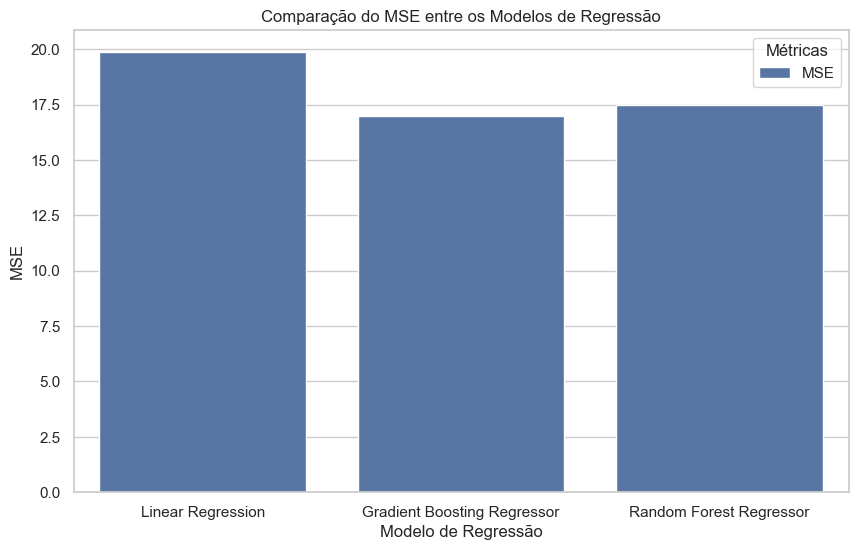

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='Valor', hue='Métricas', data=linear_metrics_melted[linear_metrics_melted['Métricas'] == 'MSE'])
plt.title('Comparação do MSE entre os Modelos de Regressão')
plt.xlabel('Modelo de Regressão')
plt.ylabel('MSE')
plt.show()

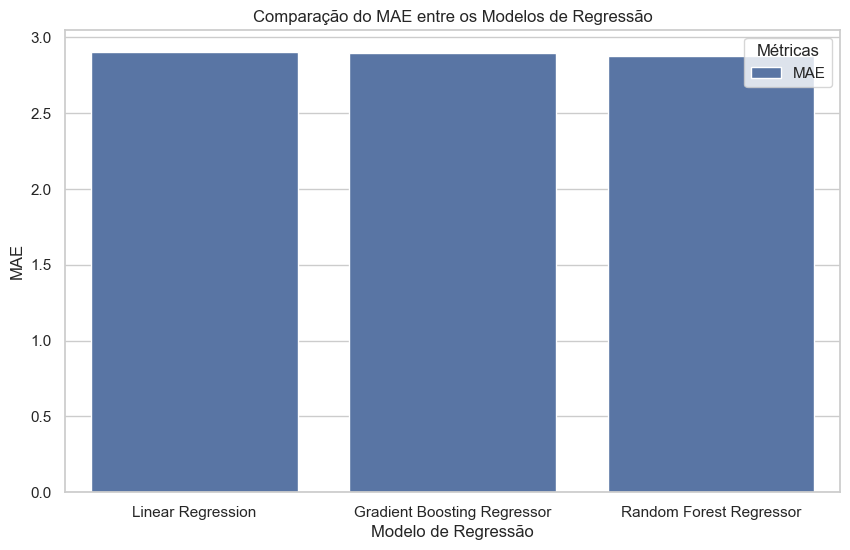

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

linear_model_data_result = {
    'Métricas': ['MSE', 'MAE', 'MAPE'],
    'Linear Regression': [mse_linear, mae_linear, mape_linear],
    'Gradient Boosting Regressor': [mse_gbr, mae_gbr, mape_gbr],
    'Random Forest Regressor': [mse_rfr, mae_rfr, mape_rfr]
}

metrics_linear_df = pd.DataFrame(linear_model_data_result)
linear_metrics_melted = metrics_linear_df.melt(id_vars='Métricas', var_name='Modelo', value_name='Valor')

plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='Valor', hue='Métricas', data=linear_metrics_melted[linear_metrics_melted['Métricas'] == 'MAE'])
plt.title('Comparação do MAE entre os Modelos de Regressão')
plt.xlabel('Modelo de Regressão')
plt.ylabel('MAE')
plt.show()

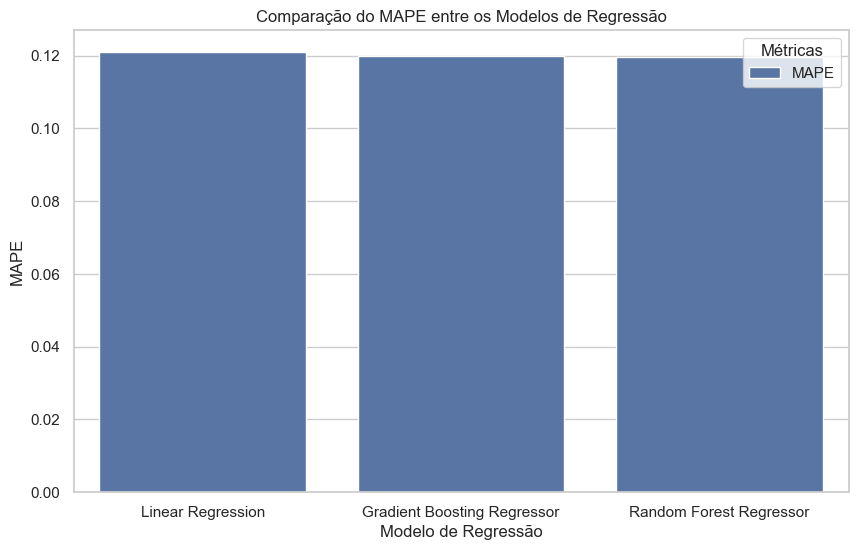

In [47]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='Valor', hue='Métricas', data=linear_metrics_melted[linear_metrics_melted['Métricas'] == 'MAPE'])
plt.title('Comparação do MAPE entre os Modelos de Regressão')
plt.xlabel('Modelo de Regressão')
plt.ylabel('MAPE')
plt.show()